In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge, ElasticNet
import warnings
import tensorflow as tf
from sklearn.decomposition import TruncatedSVD
warnings.filterwarnings('ignore')
import clearml

In [4]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ESG2JYW25TMQ8SG3QUENQHQNL99XXG
%env CLEARML_API_SECRET_KEY=F1gti6U7SrNVrM-t8tptJIeLpSzmcSHdBbC_4LHKBSTa2Xmfig3gjt2MO_2D6P15UH8

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ESG2JYW25TMQ8SG3QUENQHQNL99XXG
env: CLEARML_API_SECRET_KEY=F1gti6U7SrNVrM-t8tptJIeLpSzmcSHdBbC_4LHKBSTa2Xmfig3gjt2MO_2D6P15UH8


## Препроцесс и описательная статитстика

all_posts_v1.csv - спаршенные данные по 4 группам тематики метро

In [5]:

df_raw = pd.read_csv('../data/raw/all_posts_v1.csv')

## Data Version 1

In [ ]:
# # Версионирование сырых данных в Clear ML
# from clearml import Dataset

# # Создаем датасет ClearML
# dataset = Dataset.create(
#     dataset_name="VK_Posts_Raw",
#     dataset_project="NLP Course Project"
# )

# # Добавляем файл с данными в датасет
# dataset.add_files('../data/raw/all_posts_v1.csv')

# # Загружаем метаданные о датасете
# dataset.set_metadata({
#     'description': 'Сырые данные постов VK для NLP проекта',
#     'source': 'VK API',
#     'total_rows': len(df_raw),
#     'columns': list(df_raw.columns),
#     'data_types': str(df_raw.dtypes.to_dict()),
#     'groups_count': df_raw['group_name'].nunique(),
#     'date_range': f"{df_raw['date'].min()} - {df_raw['date'].max()}"
# })

# # Финализируем версию датасета
# dataset.finalize(auto_upload=True)

# print("✅ Сырые данные заверсионированы в Clear ML")
# print(f"📊 ID датасета: {dataset.id}")

ClearML results page: https://app.clear.ml/projects/622af47656c34ad9b3d661810c7915f5/experiments/ccfc863a8a10474e97c6fb3615748fec/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/622af47656c34ad9b3d661810c7915f5/experiments/ccfc863a8a10474e97c6fb3615748fec
Displaying metadata in the UI is only supported for pandas Dataframes for now. Skipping!
Pending uploads, starting dataset upload to https://files.clear.ml
Uploading dataset changes (1 files compressed to 15.8 MiB) to https://files.clear.ml


████████████████████████████████ 100% | 15.80/15.8 MB [00:34<00:00,  2.17s/MB]: 


File compression and upload completed: total size 15.8 MiB, 1 chunk(s) stored (average size 15.8 MiB)
✅ Сырые данные заверсионированы в Clear ML
📊 ID датасета: ccfc863a8a10474e97c6fb3615748fec


## Task Clear ml

In [ ]:
# from clearml import Task

# # Инициализация задачи
# task = Task.init(
#     project_name="NLP Course Project",
#     task_name="VK Posts EDA Analysis", 
#     task_type=Task.TaskTypes.data_processing,
#     reuse_last_task_id=False
# )

# # Логируем параметры
# task.set_parameter("dataset_path", "../data/raw/all_posts_v1.csv")
# task.set_parameter("target_group", "mosmetro")


ClearML Task: created new task id=f7da764b1fa543e3bdca91e6315f5866
======> WARNING! Git diff too large to store (10829kb), skipping uncommitted changes <======
ClearML results page: https://app.clear.ml/projects/b93684681a0643b0b06120e4b9c7d805/experiments/f7da764b1fa543e3bdca91e6315f5866/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [10]:
print(f"📊 Размер датасета: {df_raw.shape[0]} строк, {df_raw.shape[1]} колонок")
print("\n📝 Типы данных:")
print(df_raw.dtypes)

📊 Размер датасета: 72152 строк, 11 колонок

📝 Типы данных:
post_id               object
group_name            object
group_display_name    object
text                  object
comments_count         int64
likes                  int64
reposts                int64
views                  int64
date                  object
url                   object
text_length            int64
dtype: object


In [11]:
df_raw['group_name']

0           mosmetro
1           mosmetro
2           mosmetro
3           mosmetro
4           mosmetro
            ...     
72147    gazetametro
72148    gazetametro
72149    gazetametro
72150    gazetametro
72151    gazetametro
Name: group_name, Length: 72152, dtype: object

Анализ всех групп

In [12]:

group_analysis = df_raw.groupby('group_name').agg({
    'comments_count': ['count', 'sum', 'mean', 'std', 'min', 'max'],
    'likes': ['mean'],
    'views': ['mean'],
    'text_length': ['mean']
}).round(2)

 
group_analysis.columns = [
    'posts_count', 'comments_total', 'comments_mean', 'comments_std', 
    'comments_min', 'comments_max', 'likes_mean', 'views_mean', 'text_length_mean'
]

print("📈 СТАТИСТИКА ПО ГРУППАМ:")
print(group_analysis.sort_values('posts_count', ascending=False))

📈 СТАТИСТИКА ПО ГРУППАМ:
             posts_count  comments_total  comments_mean  comments_std  \
group_name                                                              
moscowmetro        40958          384319           9.38         15.01   
gazetametro        16026           34938           2.18         13.25   
mosmetro            7937          272011          34.27        141.28   
mirmetro            7231           59280           8.20         24.20   

             comments_min  comments_max  likes_mean  views_mean  \
group_name                                                        
moscowmetro             0          1477        9.13      267.83   
gazetametro             0           620       25.94     3059.32   
mosmetro                0         10749      182.99    12346.61   
mirmetro                0          1443      113.54     4355.73   

             text_length_mean  
group_name                     
moscowmetro            292.14  
gazetametro            555.24  
mosme

Не смотря на то что группа moscowmetro имеет максимальное количество постов и комментирев,при дальнейшем анализе активности последних 8 лет,большинство из них нулевые( то есть пост не содержит текста),к тому же в этой группе 384к коментов на 40к постов, мы берем mosmetro тк эта группа имеет наибольшее количество ненулевых постов и имеет соотношение 272к коментариев на 8к постов 

In [13]:
df_mosmetro = df_raw[df_raw['group_name'] == 'mosmetro'].copy()

print("📊 АНАЛИЗ ГРУППЫ MOSCOWMETRO:")
print("=" * 50)
print(f"📝 Всего постов: {len(df_mosmetro)}")
print(f"💬 Всего комментариев: {df_mosmetro['comments_count'].sum()}")
print(f"📅 Период данных: {df_mosmetro['date'].min()} - {df_mosmetro['date'].max()}")

📊 АНАЛИЗ ГРУППЫ MOSCOWMETRO:
📝 Всего постов: 7937
💬 Всего комментариев: 272011
📅 Период данных: 2014-04-20 13:04:22 - 2025-11-05 09:30:00


In [14]:
# Преобразуем дату и извлекаем компоненты времени
df_mosmetro['date'] = pd.to_datetime(df_mosmetro['date'])
df_mosmetro['year'] = df_mosmetro['date'].dt.year
df_mosmetro['month'] = df_mosmetro['date'].dt.month
df_mosmetro['year_month'] = df_mosmetro['date'].dt.to_period('M')

# Анализ по годам
print("\n📈 РАСПРЕДЕЛЕНИЕ ПО ГОДАМ:")
yearly_stats = df_mosmetro.groupby('year').agg({
    'comments_count': ['count', 'sum', 'mean'],
    'likes': ['mean'],
    'views': ['mean']
}).round(2)

yearly_stats.columns = ['posts', 'comments_total', 'comments_mean', 'likes_mean', 'views_mean']
print(yearly_stats)


📈 РАСПРЕДЕЛЕНИЕ ПО ГОДАМ:
      posts  comments_total  comments_mean  likes_mean  views_mean
year                                                              
2014   1043            6533           6.26       20.27        0.00
2015    510            8542          16.75       56.27        0.00
2016    479           10754          22.45       98.18        0.00
2017    809           23677          29.27      141.54    11620.43
2018    367           14322          39.02      179.49    16483.36
2019    426           22032          51.72      255.74    20646.98
2020    468           26732          57.12      339.36    21658.15
2021    378           17048          45.10      303.79    15838.87
2022    686           30769          44.85      263.50    18194.02
2023    932           48133          51.64      293.00    20691.85
2024   1033           32393          31.36      195.20    12414.04
2025    806           31076          38.56      170.09    16174.22


В 2017 году среднее количество комментариев на пост (29.27) выросло в 1.7 раза по сравнению с 2016 годом (22.45), а средние лайки подскочили с 98.18 до 141.54 (+44%).
тк поведение пользователей 2014-2016 года слабо коррелирует с современными привычками, мы сфокусируемся на периоде 2017-2025.

Данные за эти года вполне релевантны для прогнозирования будущего поведения.

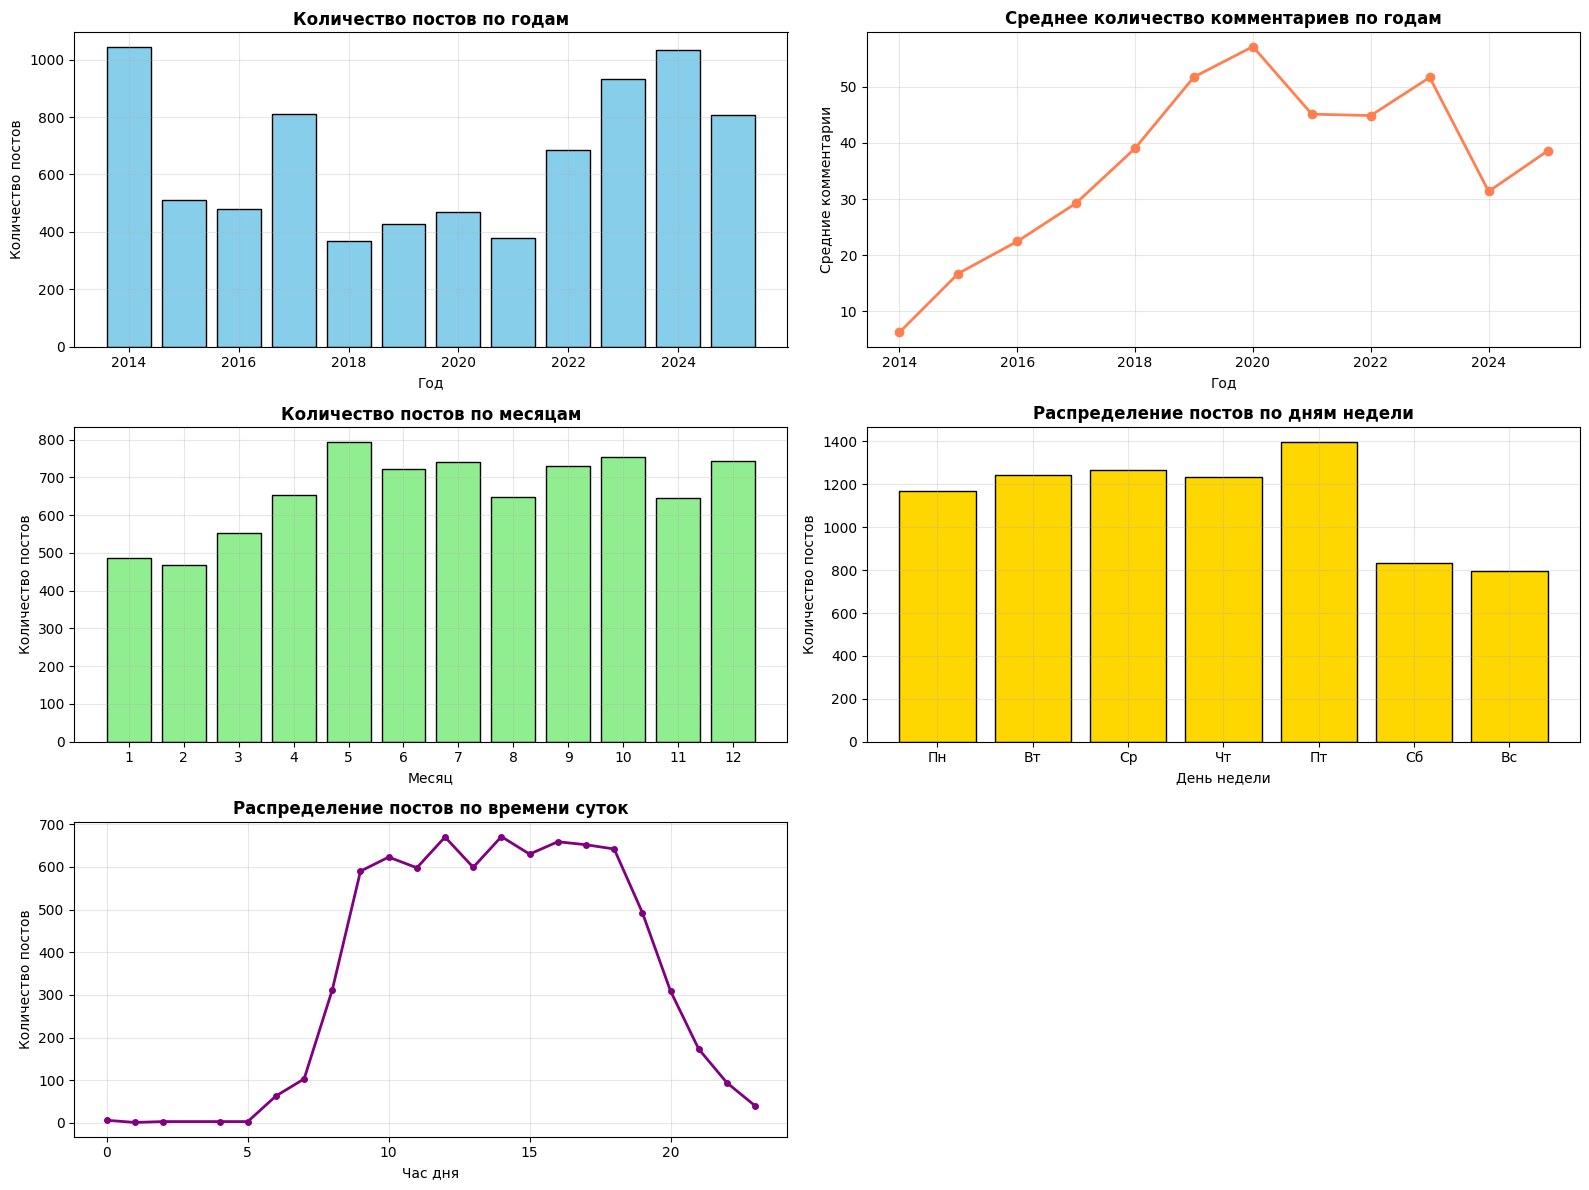

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))

# 1. Распределение постов по годам
plt.subplot(3, 2, 1)
posts_by_year = df_mosmetro['year'].value_counts().sort_index()
plt.bar(posts_by_year.index, posts_by_year.values, color='skyblue', edgecolor='black')
plt.title('Количество постов по годам', fontweight='bold', fontsize=12)
plt.xlabel('Год')
plt.ylabel('Количество постов')
plt.grid(True, alpha=0.3)

# 2. Средние комментарии по годам
plt.subplot(3, 2, 2)
mean_comments_year = df_mosmetro.groupby('year')['comments_count'].mean()
plt.plot(mean_comments_year.index, mean_comments_year.values, 'o-', linewidth=2, markersize=6, color='coral')
plt.title('Среднее количество комментариев по годам', fontweight='bold', fontsize=12)
plt.xlabel('Год')
plt.ylabel('Средние комментарии')
plt.grid(True, alpha=0.3)

# 3. Распределение по месяцам (все годы вместе)
plt.subplot(3, 2, 3)
posts_by_month = df_mosmetro['month'].value_counts().sort_index()
plt.bar(posts_by_month.index, posts_by_month.values, color='lightgreen', edgecolor='black')
plt.title('Количество постов по месяцам', fontweight='bold', fontsize=12)
plt.xlabel('Месяц')
plt.ylabel('Количество постов')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)

# 4. Активность по дням недели
plt.subplot(3, 2, 4)
df_mosmetro['day_of_week'] = df_mosmetro['date'].dt.dayofweek
days_count = df_mosmetro['day_of_week'].value_counts().sort_index()
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plt.bar(day_names, days_count.values, color='gold', edgecolor='black')
plt.title('Распределение постов по дням недели', fontweight='bold', fontsize=12)
plt.xlabel('День недели')
plt.ylabel('Количество постов')
plt.grid(True, alpha=0.3)

# 5. Распределение по часам публикации
plt.subplot(3, 2, 5)
df_mosmetro['hour'] = df_mosmetro['date'].dt.hour
hourly_count = df_mosmetro['hour'].value_counts().sort_index()
plt.plot(hourly_count.index, hourly_count.values, 'o-', linewidth=2, markersize=4, color='purple')
plt.title('Распределение постов по времени суток', fontweight='bold', fontsize=12)
plt.xlabel('Час дня')
plt.ylabel('Количество постов')
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

In [16]:

selected_years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,2025]
df_selected = df_mosmetro[df_mosmetro['year'].isin(selected_years)]

print(f"• Годы: {selected_years}")
print(f"• Постов: {len(df_selected)} ({len(df_selected)/len(df_mosmetro)*100:.1f}% от всех данных)")
print(f"• Комментариев: {df_selected['comments_count'].sum()}")
print(f"• Средние комментарии: {df_selected['comments_count'].mean():.2f}")


• Годы: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
• Постов: 5905 (74.4% от всех данных)
• Комментариев: 246182
• Средние комментарии: 41.69


In [17]:
# Анализ дубликатов
print("\n🔁 ДУБЛИКАТЫ:")
print(f"Полные дубликаты строк: {df_selected.duplicated().sum()}")
print(f"Дубликаты по тексту постов: {df_selected['text'].duplicated().sum()}")
print(f"Дубликаты по ID постов: {df_selected['post_id'].duplicated().sum()}")


🔁 ДУБЛИКАТЫ:
Полные дубликаты строк: 0
Дубликаты по тексту постов: 311
Дубликаты по ID постов: 0


In [18]:
original_size = len(df_selected)
df = df_selected.copy()
 
df_clean = df.drop_duplicates(subset=['text'], keep='first')
duplicates_removed = original_size - len(df_clean)
print(f"   Удалено дубликатов текста: {duplicates_removed}")

   Удалено дубликатов текста: 311


In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5594 entries, 0 to 5904
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   post_id             5594 non-null   object        
 1   group_name          5594 non-null   object        
 2   group_display_name  5594 non-null   object        
 3   text                5594 non-null   object        
 4   comments_count      5594 non-null   int64         
 5   likes               5594 non-null   int64         
 6   reposts             5594 non-null   int64         
 7   views               5594 non-null   int64         
 8   date                5594 non-null   datetime64[ns]
 9   url                 5594 non-null   object        
 10  text_length         5594 non-null   int64         
 11  year                5594 non-null   int32         
 12  month               5594 non-null   int32         
 13  year_month          5594 non-null   period[M]     
 1

In [20]:
df_clean.describe()

,comments_count,likes,reposts,views,date,text_length,year,month,day_of_week,hour
count,5594.000000,5594.000000,5594.000000,5.594000e+03,5594,5594.000000,5594.000000,5594.000000,5594.000000,5594.000000
mean,42.668037,220.265105,25.702002,1.649915e+04,2022-02-17 05:30:53.671254784,463.492849,2021.623346,6.596711,2.744905,14.373436
min,0.000000,27.000000,0.000000,1.060000e+03,2017-01-01 11:42:07,1.000000,2017.000000,1.000000,0.000000,0.000000
25%,9.000000,104.000000,6.000000,9.625000e+03,2019-08-20 20:18:51.500000,244.250000,2019.000000,4.000000,1.000000,11.000000
50%,22.000000,163.000000,12.000000,1.311850e+04,2022-12-14 02:08:47.500000,419.000000,2022.000000,7.000000,3.000000,14.000000
75%,45.000000,265.000000,25.000000,1.811225e+04,2024-06-28 16:07:45.750000128,617.000000,2024.000000,9.000000,4.000000,17.000000
max,10749.000000,4057.000000,835.000000,1.543454e+06,2025-11-05 09:30:00,4076.000000,2025.000000,12.000000,6.000000,23.000000
std,167.147440,200.803927,49.584932,2.847689e+04,NaN,318.954859,2.732335,3.322527,1.884800,3.553703


In [21]:
df_clean= df_clean[
    (df_clean['views'] > 1) &  # больше 1 просмотра
    (df_clean['text_length'] >=1)  # хотя бы 1 символ
]

In [22]:
df_clean.shape

(5594, 16)

In [23]:
keep_columns = [
    'text',            
    'comments_count'  
]
df_clean= df_clean[keep_columns].copy()
df_clean.head()

,text,comments_count
0,🍂 Осень — лучшее время для горячего чая и люби...,0
1,📲 Мы достигли лучших значений по стабильности ...,8
2,🎵 Концерт артистов проекта «Музыка в метро» пр...,0
3,Строить маршруты стало удобнее: мы добавили оп...,20
4,💍 100-я пара заключила брак на станции метро «...,105


In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5594 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            5594 non-null   object
 1   comments_count  5594 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 131.1+ KB


In [25]:
print("🎯 ФИНАЛЬНЫЙ ДАТАСЕТ MOSMETRO:")
print(f"📝 Постов: {len(df_clean)}")
print(f"💬 Комментариев всего: {df_clean['comments_count'].sum()}")
print(f"📈 Средние комментарии: {df_clean['comments_count'].mean():.2f}")
 
print(f"\n📊 РАСПРЕДЕЛЕНИЕ КОММЕНТАРИЕВ:")
print(df_clean['comments_count'].describe())
 
print(f"\n🔍 ДИАПАЗОН КОММЕНТАРИЕВ:")
print(f"• Мин: {df_clean['comments_count'].min()}")
print(f"• Макс: {df_clean['comments_count'].max()}")
print(f"• Медиана: {df_clean['comments_count'].median()}")

🎯 ФИНАЛЬНЫЙ ДАТАСЕТ MOSMETRO:
📝 Постов: 5594
💬 Комментариев всего: 238685
📈 Средние комментарии: 42.67

📊 РАСПРЕДЕЛЕНИЕ КОММЕНТАРИЕВ:
count     5594.000000
mean        42.668037
std        167.147440
min          0.000000
25%          9.000000
50%         22.000000
75%         45.000000
max      10749.000000
Name: comments_count, dtype: float64

🔍 ДИАПАЗОН КОММЕНТАРИЕВ:
• Мин: 0
• Макс: 10749
• Медиана: 22.0


(ограничение) выбросов - заменяем на 95%


In [26]:
# Вычисляем пороговое значение (95-й перцентиль)
percentile_95 = df_clean['comments_count'].quantile(0.95)
 
df_capped = df_clean.copy()

# Заменяем значения выше перцентиля на значение перцентиля
df_capped['comments_count'] = np.where(
    df_capped['comments_count'] > percentile_95,
    percentile_95,
    df_capped['comments_count']
)

print(f"• Максимум ДО: {df_clean['comments_count'].max()}")
print(f"• Максимум ПОСЛЕ: {df_capped['comments_count'].max()}")
print(f"• Значение 95% перцентиля: {percentile_95:.2f}")

• Максимум ДО: 10749
• Максимум ПОСЛЕ: 125.0
• Значение 95% перцентиля: 125.00


In [27]:
df_capped 

,text,comments_count
0,🍂 Осень — лучшее время для горячего чая и люби...,0.0
1,📲 Мы достигли лучших значений по стабильности ...,8.0
2,🎵 Концерт артистов проекта «Музыка в метро» пр...,0.0
3,Строить маршруты стало удобнее: мы добавили оп...,20.0
4,💍 100-я пара заключила брак на станции метро «...,105.0
...,...,...
5900,С Новым годом!\n \n/Скульптура «Пионерки с гло...,1.0
5901,Площадки проведения фестиваля «Путешествие в Р...,4.0
5902,График работы Новогоднего поезда #мосметро 1 и...,5.0
5903,"С Новым годом, друзья! :)\n\n/Скульптура «Птич...",12.0


## Task close 

In [28]:
task.close()
print("✅ Задача EDA завершена")

✅ Задача EDA завершена


## New version 2

In [32]:
# # Получаем базовую версию
# base = Dataset.get(
#     dataset_name="VK_Posts_Raw",
#     dataset_project="NLP Course Project"
# )

# print(f"📁 Базовая версия: {base.id}")

# # Создаем новую версию с ТЕМ ЖЕ ИМЕНЕМ  
# updated = Dataset.create(
#     dataset_name="VK_Posts_Raw",   
#     dataset_project="NLP Course Project",
#     parent_datasets=[base.id]   
# )

# print(f"🔄 Создана новая версия: {updated.id}")

# # Сохраняем df_capped
# temp_fixed_path = '../data/processed/df_capped_.csv'
# df_capped.to_csv(temp_fixed_path, index=False)

# # Добавляем файлы в новую версию
# updated.add_files(temp_fixed_path)

# # Устанавливаем метаданные для новой версии
# updated.set_metadata({
#     'description': 'Данные mosmetro с фиксированными выбросами комментариев - только текст и комментарии',
#     'version': '2.0',
#     'parent_dataset_id': base.id,
#     'total_posts': len(df_capped),
#     'columns_remaining': list(df_capped.columns),
#     'processing_changes': [
#         'outlier_removal_95th_percentile',
#         'column_selection_text_and_comments_only'
#     ],
#     'removed_outliers': len(df_selected) - len(df_capped),
#     'removed_percentage': f"{(len(df_selected) - len(df_capped)) / len(df_selected) * 100:.2f}%"
# })

# # Добавляем теги для версии
# updated.add_tags(['v2.0', 'outlier_fixed', 'text_only'])

# # Финализируем
# updated.finalize(auto_upload=True)

# print("✅ Новая версия датасета создана!")
# print(f"📊 Цепочка версий: {base.id} -> {updated.id}")

In [30]:

df_path = '../data/raw/df_mosmetro_sample.csv'
df_capped.to_csv(df_path, index=False, encoding='utf-8')
print("Сохранено") 

Сохранено


df_mosmetro_sample

5594 rows × 2 columns

Максимум: 125.0
Значение 95% перцентиля: 125.00

Регрессия (чистый текст)

## Предобработка текста для NLP

In [35]:
df_exp1 = df= pd.read_csv('../data/raw/df_mosmetro_sample.csv')

In [36]:
df_exp1.shape

(5594, 2)

In [37]:
df_exp1.describe()

,comments_count
count,5594.000000
mean,33.509653
std,33.387779
min,0.000000
25%,9.000000
50%,22.000000
75%,45.000000
max,125.000000


*   Приведение к нижнему регистру: Преобразуйте все слова в нижний регистр.
*   Удаление знаков пунктуации и специальных символов.
*   Удаление стоп-слов: Используйте список стоп-слов для русского языка для удаления часто встречающихся, но не несущих важную информацию для анализа слов.
*   Лемматизация: приведите слова к нормальной форме

In [38]:
import pymorphy3
import re 
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
import nltk
nltk.download('stopwords')
morph = pymorphy3.MorphAnalyzer()
def preprocess_text(text):
    """
    Предобработка текста: приведение к нижнему регистру, удаление пунктуации,
    стоп-слов и лемматизация
    """
    # Проверка на пустой текст
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Приведение к нижнему регистру
    text = text.lower().strip()
    
    # Удаление знаков пунктуации и специальных символов
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'[^а-яё\s]', ' ', text)  # оставляем только русские буквы и пробелы
    text = re.sub(r'\s+', ' ', text).strip()  # удаляем лишние пробелы
    
    # Токенизация
    tokens = word_tokenize(text, language='russian')
    
    # Удаление стоп-слов и лемматизация
    stop_words = set(stopwords.words('russian'))
    lemmas = []
    
    for token in tokens:
        if token not in stop_words and len(token) > 2:  # игнорируем короткие слова
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            lemmas.append(lemma)
    
    return " ".join(lemmas)

print("\nНачало предобработки текста...")
# Применение предобработки к столбцу с текстом. Используем tqdm для отслеживания прогресса.
if 'text' in df_exp1.columns:
    tqdm.pandas()
    df_exp1['processed_text'] = df_exp1['text'].progress_apply(preprocess_text)
    print("Предобработка текста завершена.")
    display(df_exp1.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Начало предобработки текста...


100%|██████████| 5594/5594 [00:21<00:00, 260.82it/s]

Предобработка текста завершена.


,text,comments_count,processed_text
0,🍂 Осень — лучшее время для горячего чая и люби...,0.0,осень хороший время горячее чай любимый произв...
1,📲 Мы достигли лучших значений по стабильности ...,8.0,достигнуть хороший значение стабильность интер...
2,🎵 Концерт артистов проекта «Музыка в метро» пр...,0.0,концерт артист проект музыка метро пройти моск...
3,Строить маршруты стало удобнее: мы добавили оп...,20.0,строить маршрут стать удобный добавить описани...
4,💍 100-я пара заключила брак на станции метро «...,105.0,пара заключить брак станция метро маяковский м...


In [39]:
df_exp1 =  df_exp1.dropna(subset=['processed_text'])
df_exp1 = df_exp1.query('processed_text.str.len() > 20')

df_exp1.shape

(5482, 3)

In [40]:
df_exp11 = df_exp1[['processed_text','comments_count']] 
exp1_path = '../data/processed/experiments/exp_regres.csv'
df_exp11.to_csv(exp1_path, index=False, encoding='utf-8')
print(f"💾 Сохранено: {exp1_path}")

💾 Сохранено: ../data/processed/experiments/exp_regres.csv


## Data version 3

In [41]:
# Базовая предобработка
parent_dataset_12 = Dataset.get(dataset_id='477d4366218f481d8f0aacee9dd2e9ba')
exp1_dataset = Dataset.create(
    dataset_name="VK_Posts_Raw",
    dataset_project="NLP Course Project", 
    parent_datasets=[parent_dataset_12],
) 

temp_exp1_path = '../data/processed/experiments/exp1_regress.csv'
# ваш код для создания df_exp1
df_exp11.to_csv(temp_exp1_path, index=False)

exp1_dataset.add_files(temp_exp1_path)
exp1_dataset.set_metadata({
    'description': 'Эксперимент 1: Базовая предобработка текста',
    'experiment_type': 'basic_preprocessing',
    'parent_version': '477d4366218f481d8f0aacee9dd2e9ba',
    'processing_steps': ['lowercase', 'punctuation_removal', 'basic_cleaning']
})
exp1_dataset.add_tags(['v3.0', 'preprocess_text', 'text_only'])
exp1_dataset.finalize(auto_upload=True)
print(f"✅версия 3 создана: {exp1_dataset.id}")
 

ClearML results page: https://app.clear.ml/projects/622af47656c34ad9b3d661810c7915f5/experiments/968e6deded76478aa11984bc266a4126/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/622af47656c34ad9b3d661810c7915f5/experiments/968e6deded76478aa11984bc266a4126
Displaying metadata in the UI is only supported for pandas Dataframes for now. Skipping!
Pending uploads, starting dataset upload to https://files.clear.ml
Uploading dataset changes (1 files compressed to 731.05 KiB) to https://files.clear.ml
File compression and upload completed: total size 731.05 KiB, 1 chunk(s) stored (average size 731.05 KiB)
✅версия 3 создана: 968e6deded76478aa11984bc266a4126


## Task 2


In [47]:
task = Task.init(
    project_name="NLP Course Project",
    task_name="Experiments_with_TFIDF_Models",
    task_type=Task.TaskTypes.training,
    reuse_last_task_id=False  # False - создает новый эксперимент каждый раз
)

# Получаем логгер
logger = task.get_logger()

Загружаем версионированный датасет

In [ ]:

# dataset = Dataset.get(dataset_id="968e6deded76478aa11984bc266a4126")
# dataset_path = dataset.get_local_copy()

# # Загружаем данные
# df = pd.read_csv(f"{dataset_path}/exp1_regress.csv")
# print(f"Размер датасета: {df.shape}")
# print(f"Колонки: {df.columns.tolist()}")
# print(f"\nПервые 3 строки:")
# display(df.head(3))

# # Логируем информацию о датасете в ClearML
# task.set_parameter("dataset_id", dataset.id)
# task.set_parameter("dataset_version", dataset.version)
# task.set_parameter("dataset_size", df.shape[0])

Базовое разделение данных (для всех экспериментов)

In [49]:
# Разделение данных (одинаковое для всех экспериментов)
X = df['processed_text']
y = df['comments_count']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)

print(f"Размер тренировочной выборки: {len(X_train)} (90%)")
print(f"Размер тестовой выборки: {len(X_test)} (10%)")
print(f"Пример текста: {X_train.iloc[0][:100]}...")
print(f"Целевая переменная: {y_train.iloc[0]}")

Размер тренировочной выборки: 4933 (90%)
Размер тестовой выборки: 549 (10%)
Пример текста: мосметро вызывать сыщик какой станция загадать...
Целевая переменная: 125.0


Функция для запуска одного эксперимента

In [50]:
class ExperimentRunner:
    def __init__(self, experiment_name, task, logger):
        self.experiment_name = experiment_name
        self.task = task
        self.logger = logger
        self.metrics = {}
        self.artifacts = {}
        
    def run_ridge_experiment(self, tfidf_params, ridge_params):
        """Запускает эксперимент с Ridge Regression"""
        print(f"\n{'='*60}")
        print(f"Эксперимент: {self.experiment_name}")
        print(f"{'='*60}")
        
        # Логируем параметры
        self.task.set_parameter(f"{self.experiment_name}/tfidf_params", tfidf_params)
        self.task.set_parameter(f"{self.experiment_name}/ridge_params", ridge_params)
        
        # 1. TF-IDF преобразование
        print(f"TF-IDF параметры: {tfidf_params}")
        tfidf = TfidfVectorizer(**tfidf_params)
        X_train_tfidf = tfidf.fit_transform(X_train)
        X_test_tfidf = tfidf.transform(X_test)
        
        print(f"Размерность TF-IDF: {X_train_tfidf.shape}")
        self.artifacts['tfidf'] = tfidf
        self.artifacts['X_train_tfidf_shape'] = X_train_tfidf.shape
        
        # 2. Обучение Ridge Regression
        print(f"Ridge параметры: {ridge_params}")
        model = Ridge(**ridge_params)
        model.fit(X_train_tfidf, y_train)
        
        # 3. Предсказания и метрики
        y_pred = model.predict(X_test_tfidf)
        self._calculate_metrics(y_test, y_pred)
        self.artifacts['model'] = model
        
        # 4. Визуализация предсказаний
        self._plot_predictions(y_test, y_pred)
        
        return self.metrics
    
    def run_nn_experiment(self, tfidf_params, nn_params, use_svd=False, svd_components=None):
        """Запускает эксперимент с нейросетью"""
        print(f"\n{'='*60}")
        print(f"Эксперимент: {self.experiment_name}")
        print(f"{'='*60}")
        
        # Логируем параметры
        self.task.set_parameter(f"{self.experiment_name}/tfidf_params", tfidf_params)
        self.task.set_parameter(f"{self.experiment_name}/nn_params", nn_params)
        self.task.set_parameter(f"{self.experiment_name}/use_svd", use_svd)
        
        # 1. TF-IDF преобразование
        print(f"TF-IDF параметры: {tfidf_params}")
        tfidf = TfidfVectorizer(**tfidf_params)
        X_train_tfidf = tfidf.fit_transform(X_train)
        X_test_tfidf = tfidf.transform(X_test)
        
        print(f"Размерность TF-IDF: {X_train_tfidf.shape}")
        self.artifacts['tfidf'] = tfidf
        
        # 2. SVD преобразование (если нужно)
        if use_svd and svd_components:
            print(f"Применяем SVD с {svd_components} компонентами")
            svd = TruncatedSVD(n_components=svd_components, random_state=42)
            X_train_processed = svd.fit_transform(X_train_tfidf)
            X_test_processed = svd.transform(X_test_tfidf)
            self.artifacts['svd'] = svd
            self.task.set_parameter(f"{self.experiment_name}/svd_components", svd_components)
        else:
            X_train_processed = X_train_tfidf.toarray() if hasattr(X_train_tfidf, 'toarray') else X_train_tfidf
            X_test_processed = X_test_tfidf.toarray() if hasattr(X_test_tfidf, 'toarray') else X_test_tfidf
        
        print(f"Размерность после обработки: {X_train_processed.shape}")
        
        # 3. Подготовка данных для нейросети
        if len(X_train_processed.shape) == 1:
            X_train_processed = X_train_processed.reshape(-1, 1)
            X_test_processed = X_test_processed.reshape(-1, 1)
        
        # 4. Создание модели
        print(f"Параметры нейросети: {nn_params}")
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', 
                                 kernel_regularizer=tf.keras.regularizers.l2(0.1),
                                 input_shape=(X_train_processed.shape[1],)),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(32, activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.1)),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(1)
        ])
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=nn_params.get('learning_rate', 0.001)),
            loss='mse',
            metrics=['mae']
        )
        
        # 5. Обучение
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        print("Начинаем обучение нейросети...")
        history = model.fit(
            X_train_processed, y_train,
            validation_data=(X_test_processed, y_test),
            epochs=nn_params.get('epochs', 100),
            batch_size=nn_params.get('batch_size', 32),
            callbacks=[early_stop],
            verbose=1
        )
        
        # 6. Логирование истории обучения
        self._log_training_history(history)
        
        # 7. Визуализация обучения
        self._plot_training_history(history)
        
        # 8. Предсказания и метрики
        y_pred = model.predict(X_test_processed).flatten()
        self._calculate_metrics(y_test, y_pred)
        self.artifacts['model'] = model
        
        # 9. Визуализация предсказаний
        self._plot_predictions(y_test, y_pred)
        
        return self.metrics
    
    def _calculate_metrics(self, y_true, y_pred):
        """Вычисляет метрики"""
        self.metrics['MAE'] = mean_absolute_error(y_true, y_pred)
        self.metrics['MSE'] = mean_squared_error(y_true, y_pred)
        self.metrics['RMSE'] = np.sqrt(self.metrics['MSE'])
        self.metrics['R2'] = r2_score(y_true, y_pred)
        
        print(f"\nМетрики эксперимента '{self.experiment_name}':")
        print(f"MAE: {self.metrics['MAE']:.4f}")
        print(f"MSE: {self.metrics['MSE']:.4f}")
        print(f"RMSE: {self.metrics['RMSE']:.4f}")
        print(f"R²: {self.metrics['R2']:.4f}")
        
        # Логируем метрики в ClearML
        for metric_name, value in self.metrics.items():
            self.logger.report_scalar(
                title=metric_name,
                series=self.experiment_name,
                value=value,
                iteration=0
            )
    
    def _plot_predictions(self, y_true, y_pred):
        """Визуализация предсказаний"""
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        plt.xlabel('Фактические значения')
        plt.ylabel('Предсказанные значения')
        plt.title(f'{self.experiment_name}\nПредсказания vs Факт')
        
        plt.subplot(1, 2, 2)
        residuals = y_true - y_pred
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Предсказанные значения')
        plt.ylabel('Остатки')
        plt.title('Остатки предсказаний')
        
        plt.tight_layout()
        plt.show()
        
        # Логируем график в ClearML
        self.logger.report_matplotlib_figure(
            title="Predictions Visualization",
            series=self.experiment_name,
            figure=plt.gcf(),
            iteration=0
        )
    
    def _plot_training_history(self, history):
        """Визуализация истории обучения"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.title('MAE History')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Логируем график в ClearML
        self.logger.report_matplotlib_figure(
            title="Training History",
            series=self.experiment_name,
            figure=plt.gcf(),
            iteration=0
        )
    
    def _log_training_history(self, history):
        """Логирует историю обучения в ClearML"""
        for epoch in range(len(history.history['loss'])):
            self.logger.report_scalar(
                title="Training Loss",
                series=f"{self.experiment_name}_detailed",
                value=history.history['loss'][epoch],
                iteration=epoch
            )
            self.logger.report_scalar(
                title="Validation Loss",
                series=f"{self.experiment_name}_detailed",
                value=history.history['val_loss'][epoch],
                iteration=epoch
            )

Запуск 4 экспериментов (3 обязательных + 1 дополнительный)

ЭКСПЕРИМЕНТ 1: Ridge Regression (Базовый)

Эксперимент: Ridge_Baseline
TF-IDF параметры: {'max_features': 5000, 'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.85}
Размерность TF-IDF: (4933, 5000)
Ridge параметры: {'alpha': 1.0, 'random_state': 42}

Метрики эксперимента 'Ridge_Baseline':
MAE: 20.3440
MSE: 709.7416
RMSE: 26.6410
R²: 0.3913


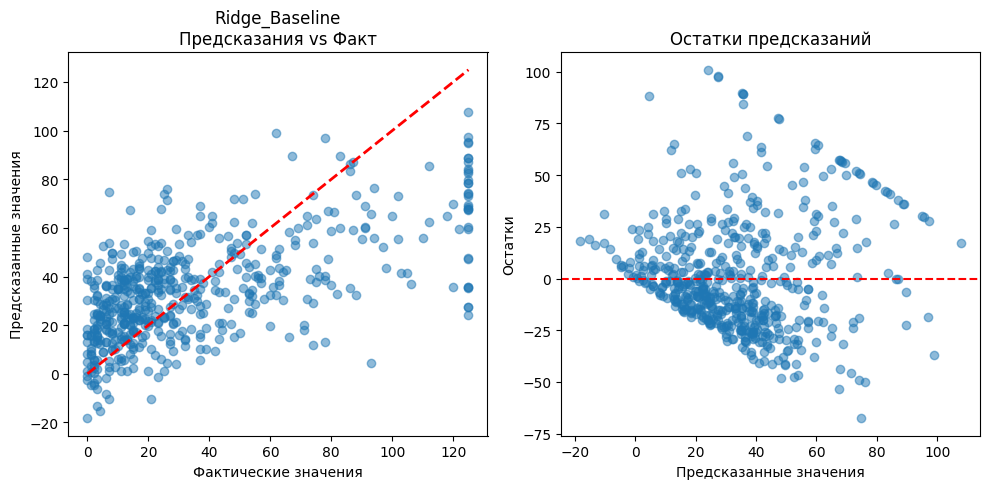


ЭКСПЕРИМЕНТ 2: Ridge Regression (Расширенный)

Эксперимент: Ridge_Extended
ClearML Monitor: Reporting detected, reverting back to iteration based reporting
TF-IDF параметры: {'max_features': 8000, 'ngram_range': (1, 3), 'min_df': 3, 'max_df': 0.8, 'sublinear_tf': True}
Размерность TF-IDF: (4933, 8000)
Ridge параметры: {'alpha': 0.5, 'random_state': 42}

Метрики эксперимента 'Ridge_Extended':
MAE: 20.5315
MSE: 723.8593
RMSE: 26.9046
R²: 0.3792


<Figure size 640x480 with 0 Axes>

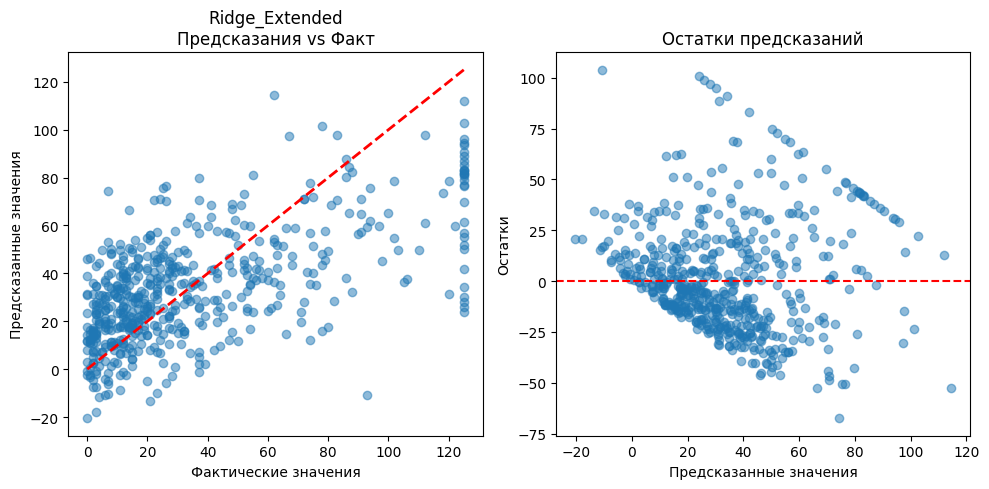


ЭКСПЕРИМЕНТ 3: Нейросеть с SVD

Эксперимент: Neural_Network_SVD
TF-IDF параметры: {'max_features': 8000, 'ngram_range': (1, 3), 'min_df': 9, 'max_df': 0.8, 'sublinear_tf': True}
Размерность TF-IDF: (4933, 5488)
Применяем SVD с 600 компонентами
Размерность после обработки: (4933, 600)
Параметры нейросети: {'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32}
Начинаем обучение нейросети...
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1988.2280 - mae: 30.4065 - val_loss: 1494.2531 - val_mae: 24.6988
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1164.8920 - mae: 24.3410 - val_loss: 1051.8812 - val_mae: 23.7726
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1042.4000 - mae: 23.5712 - val_loss: 977.6325 - val_mae: 22.9634
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 969.4285 - mae: 22.7852 - val_loss: 917.2801 - val_mae: 21.8833
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 908.0143 - mae: 21.6101 - val_loss: 86

<Figure size 640x480 with 0 Axes>

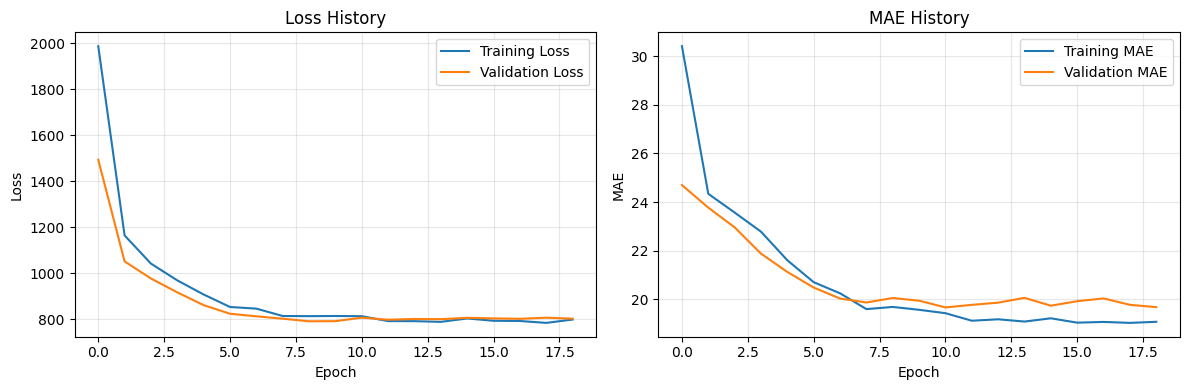

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Метрики эксперимента 'Neural_Network_SVD':
MAE: 20.0600
MSE: 748.6849
RMSE: 27.3621
R²: 0.3580


<Figure size 640x480 with 0 Axes>

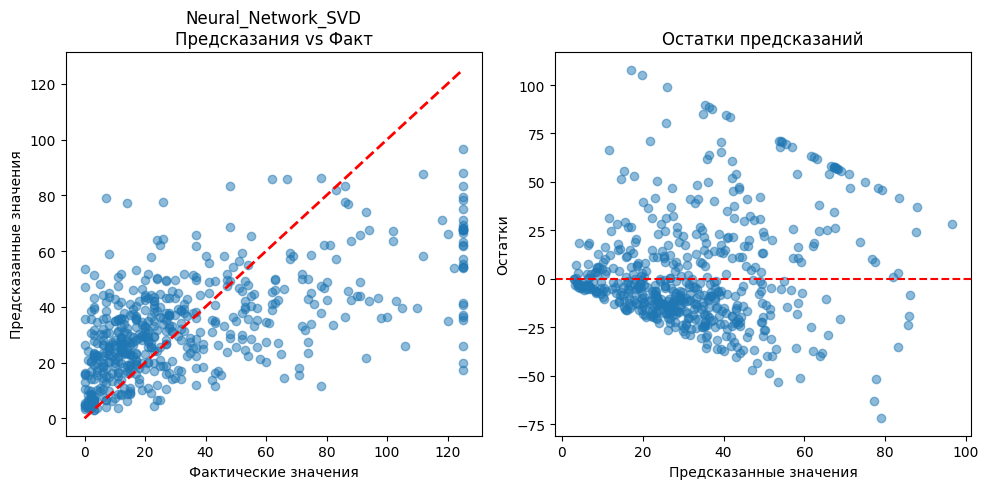


ЭКСПЕРИМЕНТ 4: Нейросеть без SVD

Эксперимент: Neural_Network_No_SVD
TF-IDF параметры: {'max_features': 4000, 'ngram_range': (1, 3), 'min_df': 9, 'max_df': 0.9, 'sublinear_tf': True}
Размерность TF-IDF: (4933, 4000)
Размерность после обработки: (4933, 4000)
Параметры нейросети: {'learning_rate': 0.0005, 'epochs': 100, 'batch_size': 32}
Начинаем обучение нейросети...
Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2127.5315 - mae: 32.0822 - val_loss: 2080.5217 - val_mae: 30.8104
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1590.7566 - mae: 26.2955 - val_loss: 1291.2148 - val_mae: 24.0842
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1206.5509 - mae: 24.6224 - val_loss: 1102.8420 - val_mae: 23.6647
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1111.1138 - mae: 23.8743 - val_loss: 1028.8156 - val_mae: 22.9814
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1054.6259 - mae: 23.0536 - val_loss: 975.0788 - val_mae: 22.3

<Figure size 640x480 with 0 Axes>

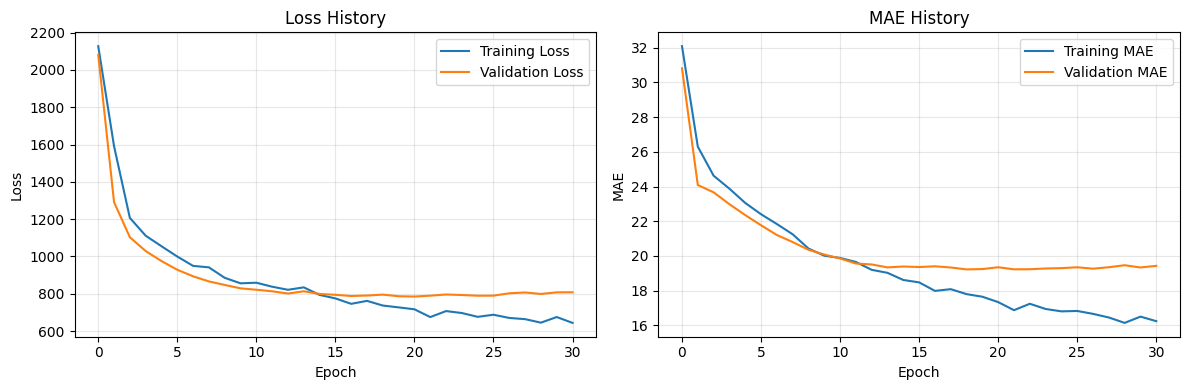

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Метрики эксперимента 'Neural_Network_No_SVD':
MAE: 19.3492
MSE: 712.7832
RMSE: 26.6980
R²: 0.3887


<Figure size 640x480 with 0 Axes>

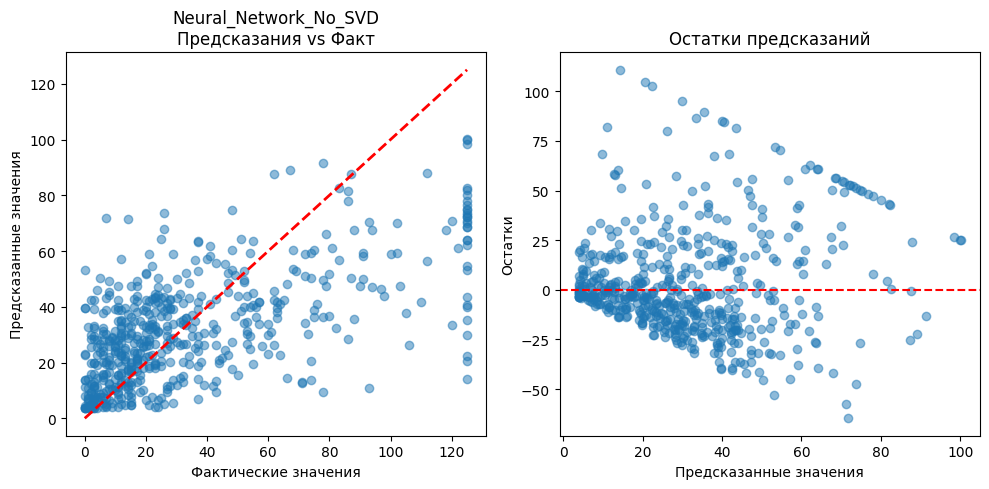

<Figure size 640x480 with 0 Axes>

In [51]:
# Создаем список для хранения результатов всех экспериментов
all_results = []

# Эксперимент 1: Ridge Regression с базовыми параметрами
print("ЭКСПЕРИМЕНТ 1: Ridge Regression (Базовый)")
exp1 = ExperimentRunner("Ridge_Baseline", task, logger)
metrics1 = exp1.run_ridge_experiment(
    tfidf_params={
        'max_features': 5000,
        'ngram_range': (1, 2),
        'min_df': 2,
        'max_df': 0.85
    },
    ridge_params={
        'alpha': 1.0,
        'random_state': 42
    }
)
metrics1['experiment'] = "Ridge_Baseline"
all_results.append(metrics1)

# Эксперимент 2: Ridge Regression с расширенными параметрами
print("\n" + "="*60)
print("ЭКСПЕРИМЕНТ 2: Ridge Regression (Расширенный)")
exp2 = ExperimentRunner("Ridge_Extended", task, logger)
metrics2 = exp2.run_ridge_experiment(
    tfidf_params={
        'max_features': 8000,
        'ngram_range': (1, 3),
        'min_df': 3,
        'max_df': 0.8,
        'sublinear_tf': True
    },
    ridge_params={
        'alpha': 0.5,
        'random_state': 42
    }
)
metrics2['experiment'] = "Ridge_Extended"
all_results.append(metrics2)

# Эксперимент 3: Нейросеть с SVD
print("\n" + "="*60)
print("ЭКСПЕРИМЕНТ 3: Нейросеть с SVD")
exp3 = ExperimentRunner("Neural_Network_SVD", task, logger)
metrics3 = exp3.run_nn_experiment(
    tfidf_params={
        'max_features': 8000,
        'ngram_range': (1, 3),
        'min_df': 9,
        'max_df': 0.8,
        'sublinear_tf': True
    },
    nn_params={
        'learning_rate': 0.001,
        'epochs': 100,
        'batch_size': 32
    },
    use_svd=True,
    svd_components=600
)
metrics3['experiment'] = "Neural_Network_SVD"
all_results.append(metrics3)

# Эксперимент 4: Нейросеть без SVD (для сравнения)
print("\n" + "="*60)
print("ЭКСПЕРИМЕНТ 4: Нейросеть без SVD")
exp4 = ExperimentRunner("Neural_Network_No_SVD", task, logger)
metrics4 = exp4.run_nn_experiment(
    tfidf_params={
        'max_features': 4000,
        'ngram_range': (1, 3),
        'min_df': 9,
        'max_df': 0.9,
        'sublinear_tf': True
    },
    nn_params={
        'learning_rate': 0.0005,
        'epochs': 100,
        'batch_size': 32
    },
    use_svd=False
)
metrics4['experiment'] = "Neural_Network_No_SVD"
all_results.append(metrics4)


СВОДНАЯ ТАБЛИЦА ЭКСПЕРИМЕНТОВ


,experiment,MAE,MSE,RMSE,R2
0,Ridge_Baseline,20.3440,709.7416,26.6410,0.3913
1,Ridge_Extended,20.5315,723.8593,26.9046,0.3792
2,Neural_Network_SVD,20.0600,748.6849,27.3621,0.3580
3,Neural_Network_No_SVD,19.3492,712.7832,26.6980,0.3887


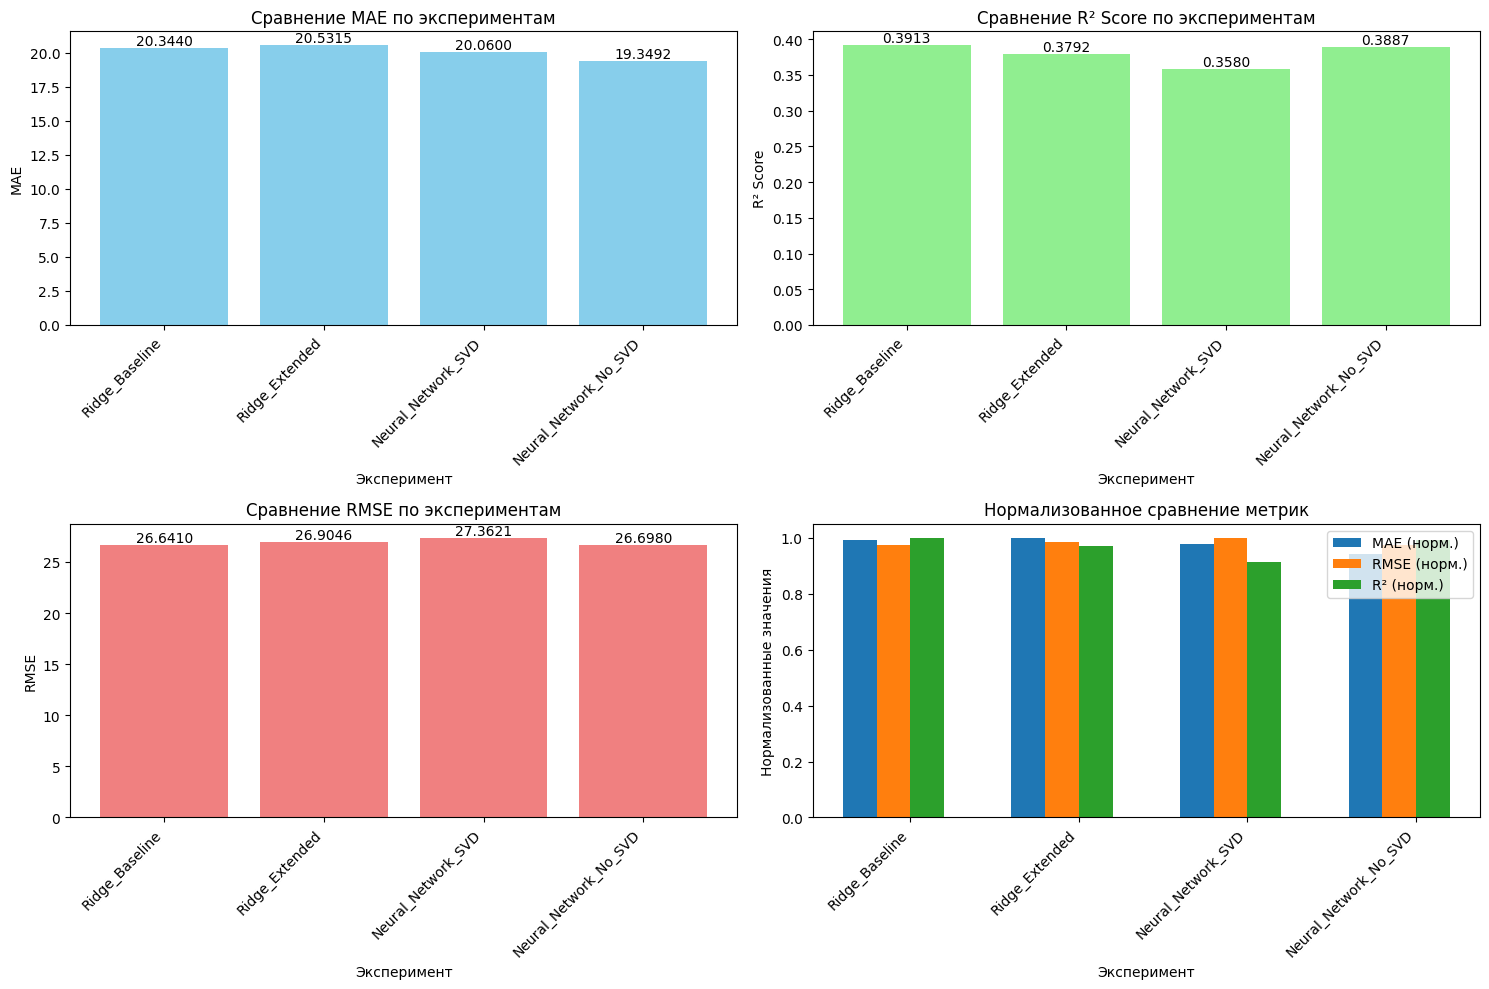

In [52]:
# Создаем таблицу сравнения
results_df = pd.DataFrame(all_results)

print("\n" + "="*60)
print("СВОДНАЯ ТАБЛИЦА ЭКСПЕРИМЕНТОВ")
print("="*60)

# Переупорядочиваем колонки
cols_order = ['experiment', 'MAE', 'MSE', 'RMSE', 'R2']
results_df = results_df[cols_order]

# Форматируем вывод
styled_df = results_df.style\
    .background_gradient(subset=['MAE', 'RMSE'], cmap='Reds_r')\
    .background_gradient(subset=['R2'], cmap='Greens')\
    .format({
        'MAE': '{:.4f}',
        'MSE': '{:.4f}',
        'RMSE': '{:.4f}',
        'R2': '{:.4f}'
    })\
    .set_caption('Сравнение результатов всех экспериментов')

display(styled_df)

# Визуализация сравнения
plt.figure(figsize=(15, 10))

# График 1: Сравнение MAE
plt.subplot(2, 2, 1)
bars = plt.bar(results_df['experiment'], results_df['MAE'], color='skyblue')
plt.xlabel('Эксперимент')
plt.ylabel('MAE')
plt.title('Сравнение MAE по экспериментам')
plt.xticks(rotation=45, ha='right')
# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

# График 2: Сравнение R²
plt.subplot(2, 2, 2)
bars = plt.bar(results_df['experiment'], results_df['R2'], color='lightgreen')
plt.xlabel('Эксперимент')
plt.ylabel('R² Score')
plt.title('Сравнение R² Score по экспериментам')
plt.xticks(rotation=45, ha='right')
# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

# График 3: Сравнение RMSE
plt.subplot(2, 2, 3)
bars = plt.bar(results_df['experiment'], results_df['RMSE'], color='lightcoral')
plt.xlabel('Эксперимент')
plt.ylabel('RMSE')
plt.title('Сравнение RMSE по экспериментам')
plt.xticks(rotation=45, ha='right')
# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

# График 4: Общее сравнение (нормализованное)
plt.subplot(2, 2, 4)
# Нормализуем метрики для сравнения
normalized = results_df.copy()
for col in ['MAE', 'MSE', 'RMSE']:
    normalized[col] = normalized[col] / normalized[col].max()
normalized['R2'] = normalized['R2'] / normalized['R2'].max()

x = np.arange(len(results_df))
width = 0.2
plt.bar(x - 1.5*width, normalized['MAE'], width, label='MAE (норм.)')
plt.bar(x - 0.5*width, normalized['RMSE'], width, label='RMSE (норм.)')
plt.bar(x + 0.5*width, normalized['R2'], width, label='R² (норм.)')
plt.xlabel('Эксперимент')
plt.ylabel('Нормализованные значения')
plt.title('Нормализованное сравнение метрик')
plt.xticks(x, results_df['experiment'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Логируем сравнение в ClearML
logger.report_matplotlib_figure(
    title="Experiments Comparison",
    series="Summary",
    figure=plt.gcf(),
    iteration=0
)

# Логируем таблицу результатов в ClearML
logger.report_table(
    title="Experiments Results Summary",
    series="Final",
    table_plot=results_df
)

plt.show()

In [53]:
# Находим лучший эксперимент по R² score
best_exp_idx = results_df['R2'].idxmax()
best_exp_name = results_df.loc[best_exp_idx, 'experiment']
best_exp_metrics = results_df.loc[best_exp_idx]

print(f"\n{'='*60}")
print(f"ЛУЧШИЙ ЭКСПЕРИМЕНТ: {best_exp_name}")
print(f"{'='*60}")
print(f"R² Score: {best_exp_metrics['R2']:.4f}")
print(f"MAE: {best_exp_metrics['MAE']:.4f}")
print(f"RMSE: {best_exp_metrics['RMSE']:.4f}")

# Сохраняем информацию о лучшей модели
task.set_parameter("best_experiment", best_exp_name)
task.set_parameter("best_r2", float(best_exp_metrics['R2']))
task.set_parameter("best_mae", float(best_exp_metrics['MAE']))

# Сохраняем финальные результаты
results_df.to_csv('experiment_results_comparison.csv', index=False)
print(f"\nРезультаты сохранены в 'experiment_results_comparison.csv'")

# Закрываем задачу (важно для ноутбука!)
task.close()
print("\nЭксперименты завершены! Проверьте результаты в интерфейсе ClearML.")


ЛУЧШИЙ ЭКСПЕРИМЕНТ: Ridge_Baseline
R² Score: 0.3913
MAE: 20.3440
RMSE: 26.6410

Результаты сохранены в 'experiment_results_comparison.csv'

Эксперименты завершены! Проверьте результаты в интерфейсе ClearML.
